In [ ]:
from google.colab import drive #Importar la base de datos desde el drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import statistics
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/Database4.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Database4/Test/bcc/ISIC_0025711.jpg  
  inflating: Database4/Test/bcc/ISIC_0025752.jpg  
  inflating: Database4/Test/bcc/ISIC_0025824.jpg  
  inflating: Database4/Test/bcc/ISIC_0025932.jpg  
  inflating: Database4/Test/bcc/ISIC_0025940.jpg  
  inflating: Database4/Test/bcc/ISIC_0026090.jpg  
  inflating: Database4/Test/bcc/ISIC_0026192.jpg  
  inflating: Database4/Test/bcc/ISIC_0026687.jpg  
  inflating: Database4/Test/bcc/ISIC_0026716.jpg  
  inflating: Database4/Test/bcc/ISIC_0026798.jpg  
  inflating: Database4/Test/bcc/ISIC_0026902.jpg  
  inflating: Database4/Test/bcc/ISIC_0026957.jpg  
  inflating: Database4/Test/bcc/ISIC_0027004.jpg  
  inflating: Database4/Test/bcc/ISIC_0027038.jpg  
  inflating: Database4/Test/bcc/ISIC_0027058.jpg  
  inflating: Database4/Test/bcc/ISIC_0027120.jpg  
  inflating: Database4/Test/bcc/ISIC_0027135.jpg  
  inflating: Database4/Test/bcc/ISIC_0027175.jpg  
  inflating: Database

In [ ]:
train_dataset = image_dataset_from_directory(
    'Database4/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='int',
)
validation_dataset = image_dataset_from_directory(
    'Database4/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='int',
)
test_dataset = image_dataset_from_directory(
    'Database4/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='int',
)

Found 2920 files belonging to 4 classes.
Found 1137 files belonging to 4 classes.
Found 946 files belonging to 4 classes.


In [ ]:
print(train_dataset.class_names)

['bcc', 'bkl', 'mel', 'nv']


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
def create_encoder():
    conv_base  = keras.applications.efficientnet_v2.EfficientNetV2B0(
        weights="imagenet",
        include_top=False,
        input_shape=(180, 180, 3),
        pooling="avg"
    )

    conv_base.trainable = True
    for layer in conv_base.layers[:-4]:
        layer.trainable = False


    inputs = keras.Input(shape=(180, 180, 3))
    augmented = data_augmentation(inputs)
    outputs = conv_base(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 32
num_epochs = 100
temperature = 0.05

24274472/24274472 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       7         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
Total params: 5919319 (22.58 MB)
Trainable params: 248320 (970.00 KB)
Non-trainable params: 5670999 (21.63 MB)
_________________________________________________________________


In [ ]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=(180, 180, 3))
    x = encoder(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(385, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model



In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=(180, 180, 3))
    features = encoder(inputs)
    outputs = layers.Dense(128, activation="relu")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from keras.callbacks import EarlyStopping
checkpoint_filepath = 'bestmodel.h5'

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
]

callbacks_list2 = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=8,
        verbose=1,
        min_lr=1e-12),
]

In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(train_dataset,
                                           batch_size=batch_size,
                                           epochs=num_epochs,
                                           validation_data=validation_dataset,
                                           verbose=1,
                                           callbacks=callbacks_list2
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 1280)              5919319   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
Total params: 6083287 (23.21 MB)
Trainable params: 412288 (1.57 MB)
Non-trainable params: 5670999 (21.63 MB)
_________________________________________________________________
Epoch 1/100
92/92 [==============================] - 23s 73ms/step - loss: 3.9469 - val_loss: 3.2667 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - 5s 47ms/step - loss: 3.2555 - val_loss: 3.2111 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - 

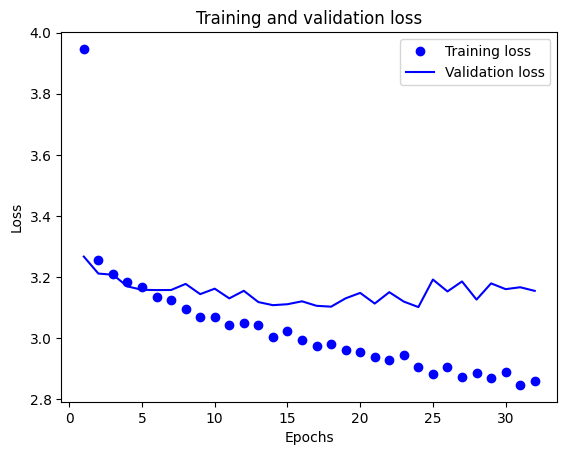

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
encoder.save("contrastive.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_dataset = image_dataset_from_directory(
    'Database4/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'Database4/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Database4/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 2920 files belonging to 4 classes.
Found 1137 files belonging to 4 classes.
Found 946 files belonging to 4 classes.


In [ ]:
classifier = create_classifier(encoder, trainable=False)
classifier.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 1280)              5919319   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 385)               493185    
                                                                 
 batch_normalization (Batch  (None, 385)               1540      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 385)               0         
                                                           

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit( train_dataset,
                          batch_size=batch_size,
                          epochs=num_epochs,
                          validation_data=validation_dataset,
                          verbose=1,
                          callbacks=callbacks_list
)


Epoch 1/100
92/92 [==============================] - 14s 68ms/step - loss: 13.5318 - accuracy: 0.7514 - val_loss: 7.2979 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - 5s 49ms/step - loss: 4.6923 - accuracy: 0.8134 - val_loss: 3.2026 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - 5s 47ms/step - loss: 2.4603 - accuracy: 0.8010 - val_loss: 2.2773 - val_accuracy: 0.7001 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - 5s 50ms/step - loss: 1.7961 - accuracy: 0.8151 - val_loss: 1.8811 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 5/100
92/92 [==============================] - 5s 48ms/step - loss: 1.5283 - accuracy: 0.8062 - val_loss: 1.6960 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 6/100
92/92 [==============================] - 5s 47ms/step - loss: 1.3861 - accuracy: 0.8024 - val_loss: 1.5130 - val_accuracy: 0.7203 - lr: 0.0010
Epoch 7/100
92/92 [==============================] - 5s 51ms/step - 

In [ ]:
print("--------------------------Test Results------------------------")
test_scores = classifier.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

--------------------------Test Results------------------------
30/30 - 1s - loss: 1.2658 - accuracy: 0.7135 - 1s/epoch - 38ms/step
Test Loss: 1.2658061981201172
Test Accuracy: 0.7135306596755981


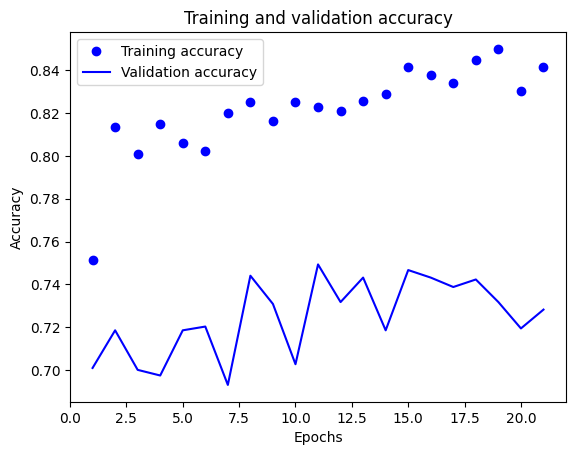

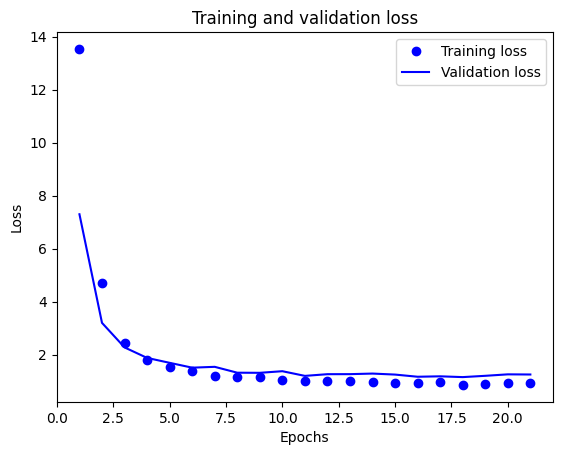

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
train_dataset = image_dataset_from_directory(
    'Database4/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 2920 files belonging to 4 classes.


In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = classifier.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 2s 2s/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       289
           1       0.69      0.95      0.80       616
           2       0.83      0.79      0.81       624
           3       0.97      0.86      0.91      1391

    accuracy                           0.86      2920
   macro avg       0.85      0.85      0.84      2920
weighted avg       0.88      0.86      0.86      2920



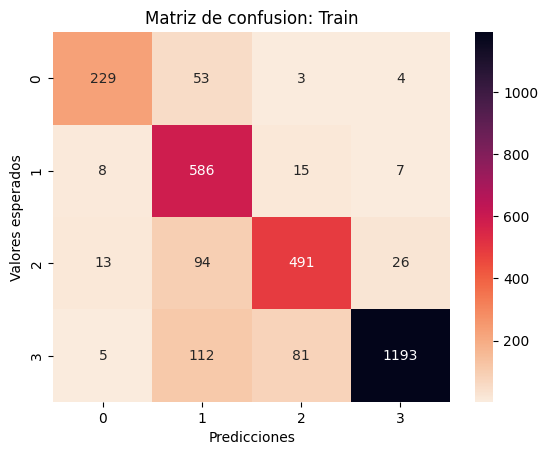

In [ ]:
#predicciones_test = model.predict(images_test)
cf = metrics.confusion_matrix(labels_train,predicciones_train)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
plt.title('Matriz de confusion: Train')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset = image_dataset_from_directory(
    'Database4/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 1137 files belonging to 4 classes.


In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = classifier.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 27ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

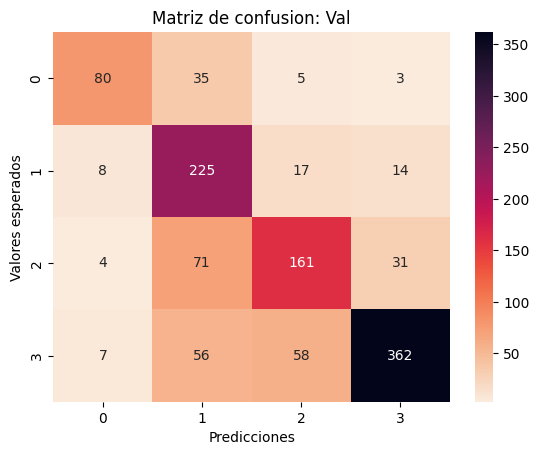

              precision    recall  f1-score   support

           0       0.81      0.65      0.72       123
           1       0.58      0.85      0.69       264
           2       0.67      0.60      0.63       267
           3       0.88      0.75      0.81       483

    accuracy                           0.73      1137
   macro avg       0.74      0.71      0.71      1137
weighted avg       0.75      0.73      0.73      1137



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)

## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
plt.title('Matriz de confusion: Val')
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset = image_dataset_from_directory(
    'Database4/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 946 files belonging to 4 classes.


In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = classifier.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 27ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

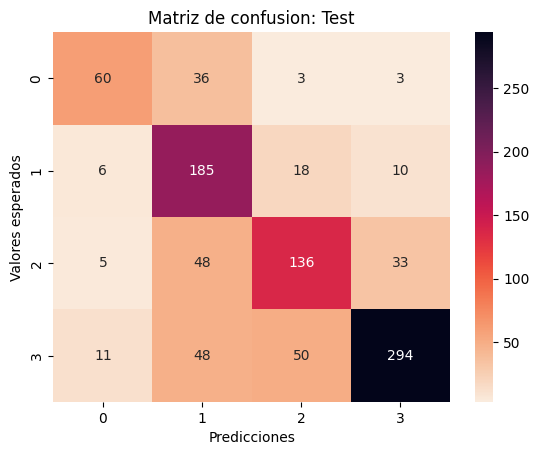

              precision    recall  f1-score   support

           0       0.73      0.59      0.65       102
           1       0.58      0.84      0.69       219
           2       0.66      0.61      0.63       222
           3       0.86      0.73      0.79       403

    accuracy                           0.71       946
   macro avg       0.71      0.69      0.69       946
weighted avg       0.74      0.71      0.72       946



In [ ]:
cf = metrics.confusion_matrix(labels_test,predicciones_test)

## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
plt.title('Matriz de confusion: Test')
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

1/1 [==============================] - 0s 29ms/step


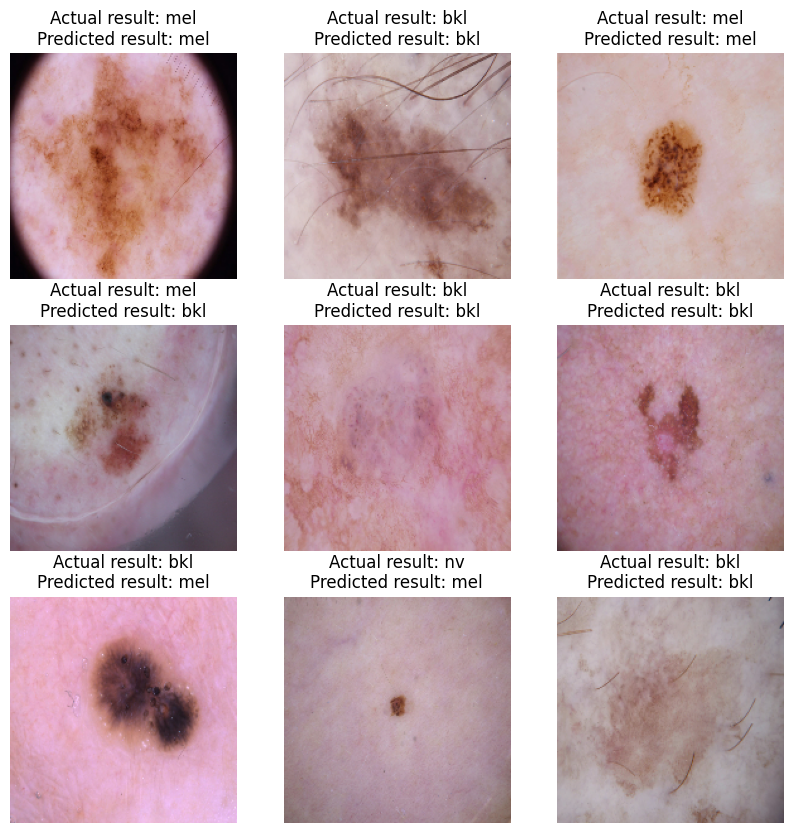

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    results = classifier.predict(images)
    max_prob = max(results[i])
    class_ind = list(results[i]).index(max_prob)
    class_name = labels[class_ind]
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual result: " + class_names[np.argmax(labels[i],axis=-1)] + "\n" + "Predicted result: " + class_names[np.argmax(class_name,axis=-1)])
    plt.axis("off")

In [ ]:
classifier.save("Modelofinal.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
tflite_model = converter.convert()

In [ ]:
#tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir = pathlib.Path(".")
tflite_model_file = tflite_models_dir/"model_contrastive.tflite"
tflite_model_file.write_bytes(tflite_model)

25401336